## Graph Visualization

In [1]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.operation:
            dot.node(name=str(id(n)) + n.operation, label=n.operation)
            dot.edge(str(id(n)) + n.operation, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operation)
    
    return dot

## Simple NN Class

### Creating Value Class

In [2]:
import math

class Value:
    def __init__(self, data, children=(), operation="", label=""):
        self.data = data
        self.label = label
        self.grad = 0
        self.operation = operation
        self.children = set(children)
        self._backward = lambda: None

    def __repr__(self):
        return f"Value object with value of {self.data}"

    # Math Operations
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, (self, other), operation="+")

        def backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad

        result._backward = backward

        return result

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, (self, other), operation="*")

        def backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad

        result._backward = backward

        return result

    def __rmul__(self, other):
        return self * other

    def __pow__(self, number):
        assert isinstance(number, (int, float))
        result = Value(self.data**number, (self,), operation=f"power of {number}")

        def backward():
            self.grad += number * (self.data**(number - 1)) * result.grad

        result._backward = backward

        return result

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self**-1

    def __sub__(self, other):
        return self + (-other)

    # Special Functions
    def exp(self):
        result = Value(math.exp(self.data), (self,), operation="exp")

        def backward():
            self.grad += result.data * result.grad

        result._backward = backward

        return result

    def tanh(self):
        result = Value(
            (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1),
            (self,),
            operation="tanh",
        )

        def backward():
            self.grad += (1 - result.data**2) * result.grad

        result._backward = backward

        return result

    # Backpropagation
    def backward_prop(self):
        sorted_list = []
        visited_nodes = set()

        def build_topological_sort(node):
            if node not in visited_nodes:
                visited_nodes.add(node)
                for child_node in node.children:
                    build_topological_sort(child_node)
                sorted_list.append(node)

        build_topological_sort(self)

        self.grad = 1.0
        for node in reversed(sorted_list):
            node._backward()


In [3]:
x1 = Value(0.5, label="x1")
x2 = Value(1.5, label="x2")
w1 = Value(1.0, label="w1")
w2 = Value(1.0, label="w2")


x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
b = Value(-1.0, label="b")

x1w1x2w2b = x1w1x2w2 + b; x1w1x2w2b.label = "x1w1x2w2b"

o = x1w1x2w2b.tanh();  o.label = "o"

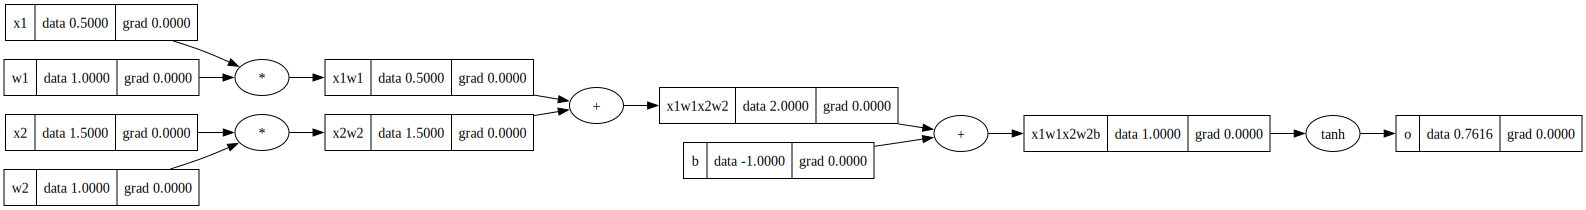

In [4]:
draw_dot(o)

In [5]:
o.grad = 1.0
o.backward_prop()

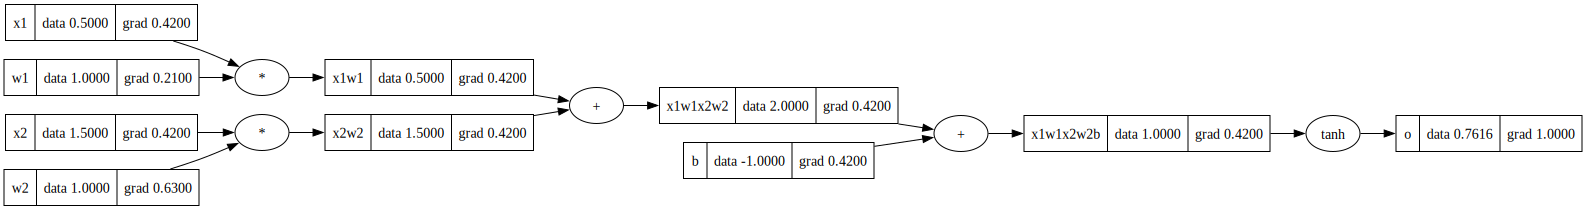

In [6]:
draw_dot(o)

### Replicating Value using Pytorch

In [7]:
import torch

x1 = torch.Tensor([0.5]).double(); x1.requires_grad = True
x2 = torch.Tensor([1.5]).double(); x2.requires_grad = True
w1 = torch.Tensor([1.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([-1.0]).double(); b.requires_grad = True


x1w1x2w2b = x1*w1 + x2*w2 + b

o = torch.tanh(x1w1x2w2b)

# o.backward()

# print(o.item())
# print("-------")
# print(round(x1.grad.item(),5))
# print(round(x2.grad.item(),5))
# print(round(w1.grad.item(),5))
# print(round(w2.grad.item(),5))
# print(round(b.grad.item(),5))

### Creating Neuron Class

A single node initialized with n_input number of weights, and a bias. 

When calling the object, takes in x of similar size to n_input number of weights, and does a linear dot product.

Then adds a bias and passes through an activation function.

In [8]:
import random

class Neuron:

    def __init__(self, n_input):
        self.w = [Value(random.uniform(-1,1)) for _ in range(n_input)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x): # calling on the object
        activation = sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b)
        output = activation.tanh()
        return output

In [9]:
x = [3, 2, 1]
n = Neuron(3)

n(x)

Value object with value of 0.8362253436450241

### Creating Layer Class

A layer of nodes

In [10]:
class Layer:

    def __init__(self, n_input, n_output):
        self.neurons = [Neuron(n_input) for _ in range(n_output)] # why all the neurons uses the same n_input, is such that the layer is fully connected

    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

In [11]:
x = [2, 3]
l = Layer(2, 3)

l(x)

[Value object with value of 0.33965079997232744,
 Value object with value of -0.5043182818559684,
 Value object with value of -0.6634346005671932]

### Creating MLP (fully connected NN) Class

Initialize a MLP with the sizes: input, output 1, output 2 ...

In [12]:
class MLP:

    def __init__(self, n_input, n_outputs):
        sizes = [n_input] + n_outputs
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(n_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [13]:
x = [2, 3, -1]
nn = MLP(3, [4, 4, 1])

nn(x)


Value object with value of 0.2831290653227599

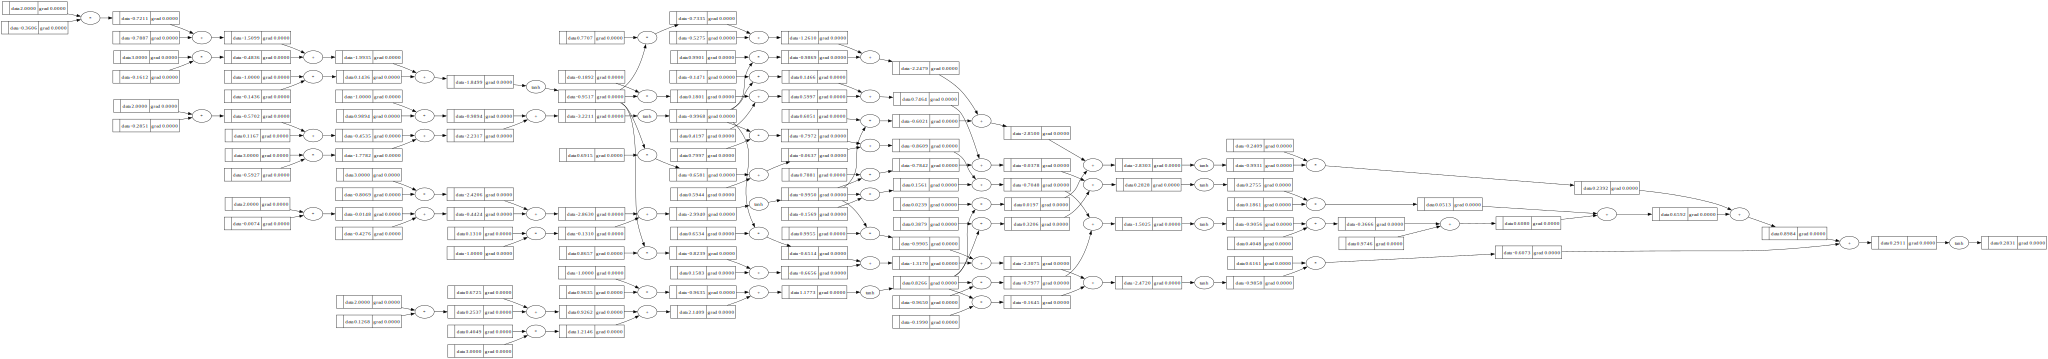

In [14]:
draw_dot(nn(x))

### Creating a tiny dataset

In [15]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, 4.0, -2.0],
    [0.5, -0.5, 3.0],
    [1.0, 2.0, -1.5],
] # Observations, 4 observations, 3 features

y_true = [1.0, 1.0, -1.0, -1.0] # labels

nn = MLP(3, [4, 4, 1])

y_pred = [nn(x) for x in xs]

y_pred

[Value object with value of -0.4038300341370427,
 Value object with value of -0.23800381383369587,
 Value object with value of 0.9631649458556643,
 Value object with value of -0.6718072402291119]

### Calculate Loss to minimize

In [16]:
losses = sum((y_out - y_in)**2 for y_out, y_in in zip(y_pred, y_true))

losses

Value object with value of 7.465119300014492

In [17]:
losses.backward_prop()

In [18]:
nn.layers[0].neurons[0].w[0]

Value object with value of -0.35202269725586355

### Adding parameters for us to tweak/nudge slightly in the Neural Network

In [19]:
import random

class Neuron:

    def __init__(self, n_input):
        self.w = [Value(random.uniform(-1,1)) for _ in range(n_input)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x): # calling on the object
        activation = sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b)
        output = activation.tanh()
        return output

    # List all parameters
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, n_input, n_output):
        self.neurons = [Neuron(n_input) for _ in range(n_output)] # why all the neurons uses the same n_input, is such that the layer is fully connected

    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    # Similarly
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, n_input, n_outputs):
        sizes = [n_input] + n_outputs
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(n_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    # Similarly
    def paramaters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [20]:
x = [2, 3, -1]
nn = MLP(3, [4, 4, 1])

nn.paramaters()

[Value object with value of 0.8182310741966059,
 Value object with value of -0.5743378618740898,
 Value object with value of 0.30227711809706603,
 Value object with value of -0.027481827853475638,
 Value object with value of -0.9340977662160719,
 Value object with value of 0.1897267195227157,
 Value object with value of 0.03247091701767202,
 Value object with value of -0.9111462320705708,
 Value object with value of 0.4692003285455173,
 Value object with value of 0.6648744922913403,
 Value object with value of 0.7316515677020903,
 Value object with value of -0.4078139973686312,
 Value object with value of 0.060347239642331685,
 Value object with value of 0.9161791715875462,
 Value object with value of -0.3343346100820439,
 Value object with value of 0.44392083003399696,
 Value object with value of 0.5608534752326357,
 Value object with value of 0.8602265233965436,
 Value object with value of 0.9378917983791784,
 Value object with value of 0.19945185719371783,
 Value object with value o

### Gradient Descent

In our gradient descent algorithm, we aim to minimize the value of loss function, therefore at any given point, we need to move in direction where the value of the function decreases the most, i.e. in the opposite direction of gradient which is direction of steepest descent.

In [21]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, 4.0, -2.0],
    [0.5, -0.5, 3.0],
    [1.0, 2.0, -1.5],
] # Observations, 4 observations, 3 features

y_true = [1.0, 1.0, -1.0, -1.0] # labels

nn = MLP(3, [4, 4, 1])

In [22]:
for iteration in range(10):
    y_pred = [nn(x) for x in xs] # Forward pass

    loss = sum((y_out - y_in)**2 for y_out, y_in in zip(y_pred, y_true)) # Find loss

    for param in nn.paramaters():
        param.grad = 0.0
    loss.backward_prop() # backward pass, always remember to 0 grad first! We implemented grad with +=, it will add up

    for param in nn.paramaters(): # gradient descent with a step size

        param.data += -0.01 * param.grad

    print(iteration, loss.data)

0 3.874798725720584
1 2.3691474334182505
2 1.8162603848749037
3 1.5490790237190357
4 1.389682406580996
5 1.273981434711016
6 1.179901379701044
7 1.0995154432669862
8 1.0293035004331164
9 0.9671905797524398


In [23]:
y_pred # much closer to prediction now

[Value object with value of 0.45526400744592843,
 Value object with value of 0.4973660032777508,
 Value object with value of -0.7366779992420469,
 Value object with value of -0.40968324822649926]